In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math
import seaborn as sns
from collections import Counter

/Users/taeyoungkee/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def u(x,a,s):
    if a == 0:
        return (1/6*s)*x + 0.5
    else: 
        def b(x):
            return 1-math.e**(-a*x)
        return (b(x)-b(-3*s))/(b(3*s)-b(-3*s))
    
def us(x_list, a, s): #utility function for the list of values           
    return [u(x, a, s) for x in x_list]

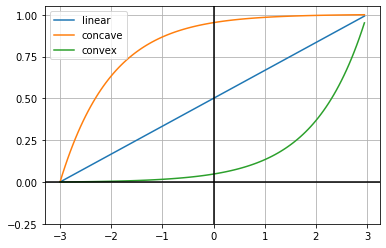

In [117]:
X = np.arange(-3,3,0.05)
Y1 = [u(x,1,1) for x in X]
Y2 = [u(x,-1,1) for x in X]
Y3 = [u(x,0,1) for x in X] 
plt.plot(X,Y3, label='linear') 
plt.plot(X,Y1, label='concave') 
plt.plot(X,Y2, label='convex') 
plt.axvline(0, color='k')
plt.axhline(0, color='k')

import matplotlib.ticker as plticker


plt.yticks(np.arange(-.25, 1.25, 0.25))

plt.grid(which='major', axis='both', linestyle='-')
plt.legend()

## Optimality gap, combined

In [5]:
def cal_opt(m, mu=0, s=1, t=1, a=0):
    out_d = {}
    
    dt = [] #list to store true decision
    d_e = [] #list to store index of maximum estimates
    d_pr = [] #list to store index of maximum posterior right way
    d_pw = [] #list to store index of maximum posterior wrong way
    
    
    o_e = [] #list to store optimality gap in estimates
    o_pr = [] #list to store og in posterior right way
    o_pw = [] # list to store og in posterior wrong way
    
    for i in range(10000):
        #Generate $m$ true values $x_j$ from the prior
        x = np.random.normal(mu,s,m) #x_j~N(0,1)
        u_x = us(x, a, s)
        
        #index of the right decision
        max_ux = max(u_x)
        max_ix = u_x.index(max_ux) #index of true maximum
        dt.append(max_ix) 

        #For each true value, generate an estimate $y_j$ from the likelihood 
        y = [np.random.normal(x_j,t,1)[0] for x_j in x] #y_j~N(x_j,1)
        u_y = us(y, a, s)
        
        max_uy = max(u_y) #maximum estimates
        max_j = u_y.index(max_uy) #index of maximum estimates
        d_e.append(max_j) 
        
        #Otimality gap estimates 
        d = (max(u_x) - u(x[max_j], a, s))/max(u_x)
        o_e.append(d)
        
        
        #For each $y_j$, generate 1000 true values $x_jk$ from $(X|Y=y)=N(sigma^2/(tau^2 +sigma^2)*y_j+tau^2/(sigma^2+tau^2)*overline(mu)), k=1,...1000$
        x_p = []
        for y_j in y:
            p_mean = (t**2/(s**2 + t**2))*mu + (s**2/(s**2 + t**2))*y_j
            p_std = (s**2*t**2/(s**2 + t**2)) #caution! it is variance

            x_p.append(list(np.random.normal(p_mean, np.sqrt(p_std),1000)))


        #Compute $u(x_jk$) for all $j,k$
        u_x_p = [us(x, a, s) for x in x_p]

        #Compute the average $\sum_{k=1}^1000 u_(x_jk)$ to get an estimate for the expected utility $E[u(X_j)|Y_j=y_j]$
        eu = [np.mean(x) for x in u_x_p]

        #Choose the alternative $j^$ with the highest expected utility
        max_eu = max(eu)
        max_j2 = eu.index(max_eu)
        d_pr.append(max_j2)     

        #posterior disappointment 
        d = (max(u_x) - u(x[max_j2], a, s))/max(u_x)
        o_pr.append(d)
        
        
        #For each $y_j$, generate 1000 true values $x_jk$ from $(X|Y=y)=N(sigma^2/(tau^2 +sigma^2)*y_j+tau^2/(sigma^2+tau^2)*overline(mu)), k=1,...1000$
        x_p = []
        for y_j in y:
            p_mean = (t**2/(s**2 + t**2))*mu + (s**2/(s**2 + t**2))*y_j
            x_p.append(p_mean)

        eu = [u(x,a,s) for x in x_p]

        #Choose the alternative $j^$ with the highest expected utility
        max_eu = max(eu)
        max_j3 = eu.index(max_eu)
        d_pw.append(max_j3)

        #posterior disappointment 
        d = (max(u_x) - u_x[max_j3])/max(u_x) 
        o_pw.append(d)
        
    #Compute the difference $u(x_\tilde{j})-\sum_{k=1}^1000 u_(x_\tilde{j}k)$
    
    out_d["dt"] = dt
    out_d["d_e"] = d_e
    out_d["d_pr"] = d_pr
    out_d["d_pw"] = d_pw
    
    out_d["o_e"] = o_e
    out_d["o_pr"] = o_pr
    out_d["o_pw"] = o_pw
    
    print("Number of different decision between true & estimated")
    print(Counter((np.array(dt)-np.array(d_e))))
    print()
    print("Number of different decision between true & posterior right way")
    print(Counter((np.array(dt)-np.array(d_pr))))
    print()
    print("Number of different decision between true & posterior wrong way")
    print(Counter((np.array(dt)-np.array(d_pw))))

    print("Mean of relative optimality gap between true & estimated")
    print(np.mean(o_e))
    print()
    print("Mean of relative optimality gap between true & posterior right way")
    print(np.mean((o_pr)))
    print()
    print("Mean of relative optimality gap between true & posterior wrong way")
    print(np.mean((o_pw)))
    return out_d

for m in [2,3,5,10]:
    print("m", m)
    cal_opt(m=m)
    print("")

# Posterior disappointment - multiattribute estimates

In [143]:
def cal_post_mu(m=5, mu=[0,0,0], s=[1,1,1], t=[1,1,1], w=[1/3, 1/3, 1/3], a=[0,0,0]):
    
    out_d = {}
    
    dt = [] #list to store true decision
    d_e = [] #list to store index of maximum estimates
    d_pr = [] #list to store index of maximum posterior right way
    d_pw = [] #list to store index of maximum posterior wrong way
    
    
    o_e = [] #list to store optimality gap in estimates
    o_pr = [] #list to store og in posterior right way
    o_pw = [] # list to store og in posterior wrong way
    
    o1 = []
    o2 = []
    
    def cal_u(multiatt):
        ul = [u(multiatt[i], a[i], 1) for i in range(len(multiatt))]
        return np.dot(w, ul)
    
    for k in range(1000):
        x = []
        eu = []
        eu_pr = []
        eu_pw = []

        for j in range(m): #loop for generating mu alternatives
            
            n = len(mu) #number of attributes
            x_j = [np.random.normal(mu[i], s[i],1)[0] for i in range(n)] #generate true mu of one alternative
            x.append(cal_u(x_j)) #append the utility of one mu alternative u(x_j)           
            
            y_j = [np.random.normal(x_j[i], t[i],1)[0] for i in range(n)] #generate estimated mu of one alternative            
            eu.append(cal_u(y_j)) #append the utility of one mu estimates u(y_j)
            
            u_x_jp_l_r = [] #list to store 1000 u(x) of posterior u of one mu alternative 
            u_x_jp_l_w = []
            
            x_jp_r = [] #one alternative, right way
            x_jp_w = [] #one alternative, wrong way
            
            for i in range(n): #loop for generating posterior mu for one alternative
                p_mean = (t[i]**2/(s[i]**2 + t[i]**2))*mu[i] + (s[i]**2/(s[i]**2 + t[i]**2))*y_j[i]
                p_var = (s[i]**2*t[i]**2/(s[i]**2 + t[i]**2)) 
                
                x_p_ji = list(np.random.normal(p_mean, np.sqrt(p_var),1000))
                
                #right way
                x_jp_r.append(np.mean(us(x_p_ji, a[i], 1)))
                #wrong way
                x_jp_w.append(np.mean(x_p_ji))

            #wrong way
            eu_pw.append(cal_u(x_jp_w)) #append u(x) of one posterior alternative (repeated 1000 times)            
            
            #right way
            eu_pr.append(np.dot(w, x_jp_r)) #append w_i*E[u(x)|y]
            
        #index of true max
        max_ix = x.index(max(x))
        dt.append(max_ix)
              
        ###Saving result from estimates
        #Choose the alternative $j^$ with the highest expected utility
        max_eu = max(eu)
        max_j = eu.index(max_eu)
        d_e.append(max_j)

        #disappointment 
        d = (x[max_j] - max_eu)/max_eu
        o_e.append(d)
        
        ###Saving result from posterior right way
        #Choose the alternative $j^$ with the highest expected utility
        max_eu1 = max(eu_pr)
        max_j1 = eu_pr.index(max_eu1)
        d_pr.append(max_j1)
        
        #disappointment 
        d2 = (x[max_j1]-max_eu1)/max_eu1
        o_pr.append(d2)
        
        #optimality gap E[u(Z_{\kappa(Z)}-u(Z_{\kappa(u(Y))}] 
        o1.append(eu_pr[max_j]/max_eu1)
        

        ###Saving result from posterior wrong way
        #Choose the alternative $j^$ with the highest expected utility
        max_eu2 = max(eu_pw)
        max_j2 = eu_pw.index(max_eu2)
        d_pw.append(max_j2)

        #disappointment 
        d3 = (x[max_j2]-max_eu2)/max_eu2
        o_pw.append(d3)    
        
        #optimality gap E[u(Z_{\kappa(Z)}-u(Z_{\kappa(\tilde{Z})}] 
        o2.append(eu_pr[max_j2]/max_eu1)
        
        
    out_d["dt"] = dt
    out_d["d_e"] = d_e
    out_d["d_pr"] = d_pr
    out_d["d_pw"] = d_pw
    
    out_d["o_e"] = o_e
    out_d["o_pr"] = o_pr
    out_d["o_pw"] = o_pw
    
    out_d["o1"] = o1
    out_d["o2"] = o2
    
    
    
 #  print("Number of different decision between true & estimated")
 #  print(Counter((np.array(dt)-np.array(d_e))))
 #  print()
 #  print("Number of different decision between true & posterior right way")
 #  print(Counter((np.array(dt)-np.array(d_pr))))
 #  print()
 #  print("Number of different decision between true & posterior wrong way")
 #  print(Counter((np.array(dt)-np.array(d_pw))))
 #  print()
 #  print("Mean of relative post decision disappointment between true & estimated")
 #  print(np.mean(o_e))
 #  print()
 #  print("Mean of relative post decision disappointment between true & posterior right way")
 #  print(np.mean((o_pr)))
 #  print()
 #  print("Mean of relative post decision disappointment between true & posterior wrong way")
 #  print(np.mean((o_pw)))
 #      
        
        #Compute the difference $u(x_\tilde{j})-\sum_{k=1}^1000 u_(x_\tilde{j}k)$
    return out_d

In [122]:
r = cal_post_mu(m=5, a = [0]*5)


In [123]:
np.sum((np.array(r["dt"]) - np.array(r["d_e"])) != 0)

46

In [145]:
diff_e = []
diff_pr = []
diff_pw = []

o_e = []
o_pr = []
o_pw = []

o1 = []
o2 = []


for a in np.arange(-1, 1, 0.1):
    print(a)
    r = cal_post_mu(m=5, a=[a]*3, t=[1]*3)

    diff_e.append(np.sum((np.array(r["dt"]) - np.array(r["d_e"]))!=0))
    diff_pr.append(np.sum((np.array(r["dt"]) - np.array(r["d_pr"]))!=0))
    diff_pw.append(np.sum((np.array(r["dt"]) - np.array(r["d_pw"]))!=0))

    o_e.append(np.mean(r["o_e"]))
    o_pr.append(np.mean(r["o_pr"]))
    o_pw.append(np.mean(r["o_pw"]))

    o1.append(np.mean(r["o1"]))
    o2.append(np.mean(r["o2"]))
    


-1.0
-0.9
-0.8
-0.7000000000000001
-0.6000000000000001
-0.5000000000000001
-0.40000000000000013
-0.30000000000000016
-0.20000000000000018
-0.1000000000000002
-2.220446049250313e-16
0.09999999999999964
0.19999999999999973
0.2999999999999998
0.3999999999999997
0.49999999999999956
0.5999999999999996
0.6999999999999997
0.7999999999999996
0.8999999999999995


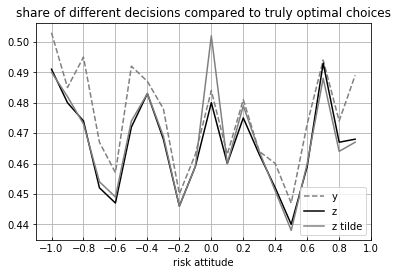

In [184]:
#average number of difference decision out of 1000 decisions
xticks = list(np.arange(-1, 1.1, 0.2))
plt.plot(np.arange(-1, 1, 0.1),np.array(diff_e)/1000, color="gray", ls="dashed", label="y")
plt.plot(np.arange(-1, 1, 0.1),np.array(diff_pr)/1000, color="black", label="z")
plt.plot(np.arange(-1, 1, 0.1),np.array(diff_pw)/1000, color="gray", label = "z tilde")
plt.tick_params(axis="x", direction="in")
plt.xticks(xticks)
plt.xlabel("risk attitude")
plt.title("share of different decisions compared to truly optimal choices")
plt.legend()
plt.grid(True)
plt.show()

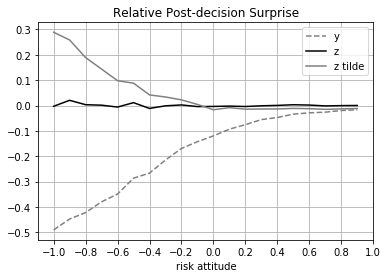

In [185]:
#post-decision surprise (relative)
xticks = list(np.arange(-1, 1.1, 0.2))

plt.plot(np.arange(-1, 1, 0.1),o_e, color="gray", ls="dashed", label='y')
plt.plot(np.arange(-1, 1, 0.1),o_pr, color="black", label='z')
plt.plot(np.arange(-1, 1, 0.1),o_pw, color="gray", label='z tilde')
plt.xticks(xticks)
plt.xlabel("risk attitude")
plt.title("Relative Post-decision Surprise")
plt.legend()
plt.grid(True)
plt.show()

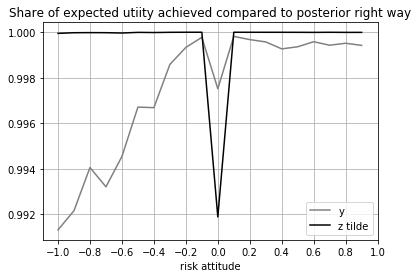

In [186]:
#E[u(Z_{\kappa(Z)}-u(Z_{\kappa(Y)}] 
xticks = list(np.arange(-1, 1.1, 0.2))

plt.plot(np.arange(-1, 1, 0.1),o1, color="gray", label='y')
#E[u(Z_{\kappa(Z)}-u(Z_{\kappa(\tilde{Z})}] 
plt.plot(np.arange(-1, 1, 0.1),o2, color="black", label='z tilde')
plt.xticks(xticks)
plt.xlabel("risk attitude")
plt.title("Share of expected utiity achieved compared to posterior right way")
plt.grid(True)
plt.legend()
plt.show()


In [149]:
diff_e1 = []
diff_pr1 = []
diff_pw1 = []

o_e1 = []
o_pr1 = []
o_pw1 = []

o11 = []
o21 = []


for t in np.arange(0, 10, 0.1):
    print(t)
    r = cal_post_mu(m=5, t=[1,1,t,1,1])
    diff_e1.append(np.sum(np.array(r["dt"]) - np.array(r["d_e"]) !=0))
    diff_pr1.append(np.sum(np.array(r["dt"]) - np.array(r["d_pr"])!=0))
    diff_pw1.append(np.sum(np.array(r["dt"]) - np.array(r["d_pw"])!=0))
    
    o_e1.append(np.mean(r["o_e"]))
    o_pr1.append(np.mean(r["o_pr"]))
    o_pw1.append(np.mean(r["o_pw"]))
    
    o11.append(np.mean(r["o1"]))
    o21.append(np.mean(r["o2"]))
   

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2
6.300000000000001
6.4
6.5
6.6000000000000005
6.7
6.800000000000001
6.9
7.0
7.1000000000000005
7.2
7.300000000000001
7.4
7.5
7.6000000000000005
7.7
7.800000000000001
7.9
8.0
8.1
8.200000000000001
8.3
8.4
8.5
8.6
8.700000000000001
8.8
8.9
9.0
9.1
9.200000000000001
9.3
9.4
9.5
9.600000000000001
9.700000000000001
9.8
9.9


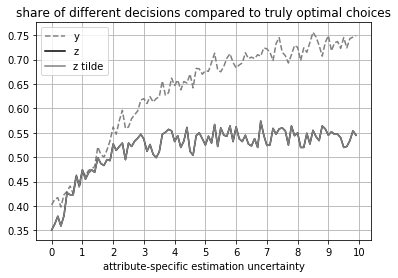

In [193]:
#average number of difference decision out of 1000 decisions
xticks = list(np.arange(0, 11, 1))

plt.plot(np.arange(0, 10, 0.1), np.array(diff_e1)/1000, color="gray", ls="dashed", label='y')
plt.plot(np.arange(0, 10, 0.1), np.array(diff_pr1)/1000, color="black", label='z')
plt.plot(np.arange(0, 10, 0.1), np.array(diff_pw1)/1000, color="gray", label='z tilde')

plt.xlabel("attribute-specific estimation uncertainty")
plt.title("share of different decisions compared to truly optimal choices")
plt.xticks(xticks)
plt.legend()
plt.grid(True)
plt.show()

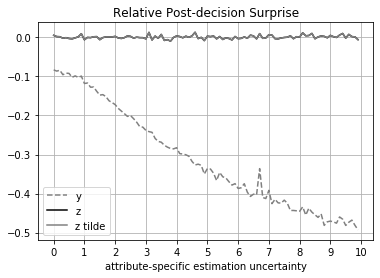

In [194]:
#post-decision surprise (relative)
xticks = list(np.arange(0, 11, 1))


plt.plot(np.arange(0, 10, 0.1),o_e1, color="gray", ls="dashed", label='y')
plt.plot(np.arange(0, 10, 0.1),o_pr1, color="black", label='z')
plt.plot(np.arange(0, 10, 0.1),o_pw1, color="gray", label='z tilde')
plt.xlabel("attribute-specific estimation uncertainty")
plt.title("Relative Post-decision Surprise")
plt.legend()
plt.xticks(xticks)
plt.grid(True)
plt.show()

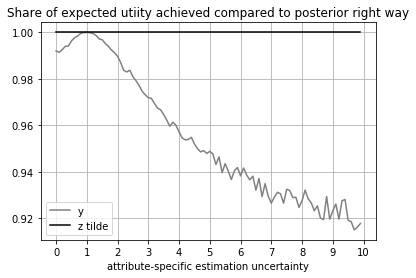

In [195]:
xticks = list(np.arange(0, 11, 1))


#E[u(Z_{\kappa(Z)}-u(Z_{\kappa(Y)}] 
plt.plot(np.arange(0, 10, 0.1),o11, color="gray", label='y')
#E[u(Z_{\kappa(Z)}-u(Z_{\kappa(\tilde{Z})}] 
plt.plot(np.arange(0, 10, 0.1),o21, color="black", label='z tilde')
plt.legend()
plt.xlabel("attribute-specific estimation uncertainty")
plt.title("Share of expected utiity achieved compared to posterior right way")
plt.xticks(xticks)
plt.grid(True)
plt.show()

In [12]:
for m in [2,3,5,10]:
    print("m", m)
    cal_post_mu(m=m) #Increasing number of alternative
    print()

m 2
Number of different decision between true & estimated
Counter({0: 766, 1: 124, -1: 110})

Number of different decision between true & posterior right way
Counter({0: 767, 1: 122, -1: 111})

Number of different decision between true & posterior wrong way
Counter({0: 767, 1: 122, -1: 111})

Mean of relative post decision disappointment between true & estimated
-0.04882638974824727

Mean of relative post decision disappointment between true & posterior right way
0.0001515281298639195

Mean of relative post decision disappointment between true & posterior wrong way
0.00015152812986391195

m 3
Number of different decision between true & estimated
Counter({0: 661, 1: 126, -1: 113, 2: 52, -2: 48})

Number of different decision between true & posterior right way
Counter({0: 654, 1: 126, -1: 115, 2: 53, -2: 52})

Number of different decision between true & posterior wrong way
Counter({0: 654, 1: 126, -1: 115, 2: 53, -2: 52})

Mean of relative post decision disappointment between true & esti

In [18]:
for t in [2,3,5,10]:
    print("t", t)
    cal_post_mu(m=5, t=[1,1,t,1,1]) #Increasing estimation uncertainity of one attribute
    print()

t 2
Number of different decision between true & estimated
Counter({0: 455, -1: 128, 1: 108, 2: 80, 3: 64, -2: 62, -3: 43, -4: 33, 4: 27})

Number of different decision between true & posterior right way
Counter({0: 497, -1: 108, 1: 105, 2: 73, 3: 59, -3: 55, -2: 54, -4: 25, 4: 24})

Number of different decision between true & posterior wrong way
Counter({0: 497, -1: 108, 1: 105, 2: 73, 3: 59, -3: 55, -2: 54, -4: 25, 4: 24})

Mean of relative post decision disappointment between true & estimated
-0.16879243692921006

Mean of relative post decision disappointment between true & posterior right way
-0.0007121019463560963

Mean of relative post decision disappointment between true & posterior wrong way
-0.0007121019463561007

t 3
Number of different decision between true & estimated
Counter({0: 392, 1: 127, -1: 126, 2: 102, -2: 76, -3: 66, 3: 49, -4: 32, 4: 30})

Number of different decision between true & posterior right way
Counter({0: 465, -1: 114, 1: 98, 2: 92, -2: 65, 3: 61, -3: 57, -

In [19]:
for t in [2,3,5,10]:
    print("t", t)
    cal_post_mu(m=5, t=[1,1,t,1,1], a=[0.367]*5) #Increasing estimation uncertainity of one attribute
    print()

t 2
Number of different decision between true & estimated
Counter({0: 497, -1: 104, 1: 101, -2: 81, 2: 73, -3: 49, 3: 45, 4: 27, -4: 23})

Number of different decision between true & posterior right way
Counter({0: 506, -1: 107, 1: 90, 2: 79, -2: 77, -3: 51, 3: 47, 4: 22, -4: 21})

Number of different decision between true & posterior wrong way
Counter({0: 507, -1: 106, 1: 89, 2: 79, -2: 77, -3: 51, 3: 48, 4: 22, -4: 21})

Mean of relative post decision disappointment between true & estimated
-0.06881610259022147

Mean of relative post decision disappointment between true & posterior right way
0.002736400772951908

Mean of relative post decision disappointment between true & posterior wrong way
-0.014301871678921635

t 3
Number of different decision between true & estimated
Counter({0: 417, -1: 121, -2: 106, 1: 99, 2: 81, 3: 65, -3: 52, -4: 33, 4: 26})

Number of different decision between true & posterior right way
Counter({0: 473, -1: 113, 1: 92, -2: 81, 2: 78, 3: 62, -3: 48, -4: 29,

In [20]:
for t in [2,3,5,10]:
    print("t", t)
    cal_post_mu(m=5, t=[1,1,t,1,1], a=[-0.367]*5) #Increasing estimation uncertainity of one attribute
    print()

t 2
Number of different decision between true & estimated
Counter({0: 419, -1: 128, 1: 123, -2: 92, 2: 78, 3: 57, -3: 51, -4: 27, 4: 25})

Number of different decision between true & posterior right way
Counter({0: 473, -1: 110, 1: 104, -2: 85, 2: 69, -3: 54, 3: 51, -4: 32, 4: 22})

Number of different decision between true & posterior wrong way
Counter({0: 474, -1: 110, 1: 105, -2: 84, 2: 69, -3: 53, 3: 52, -4: 32, 4: 21})

Mean of relative post decision disappointment between true & estimated
-0.378434553110241

Mean of relative post decision disappointment between true & posterior right way
-0.005742294154791905

Mean of relative post decision disappointment between true & posterior wrong way
0.050867801469786374

t 3
Number of different decision between true & estimated
Counter({0: 332, -1: 156, 1: 129, 2: 102, -2: 94, -3: 76, 3: 59, 4: 27, -4: 25})

Number of different decision between true & posterior right way
Counter({0: 444, 1: 116, -1: 113, -2: 91, 2: 77, 3: 56, -3: 54, 4: 29

In [147]:
def cal_post_mu(m=5, mu=[0,0,0], s=[1,1,1], t=[1,1,1], w=[1/3, 1/3, 1/3], a=[0,0,0]):
    
    def cal_u(multiatt):
        ul = [u(multiatt[i], a[i], 1) for i in range(len(multiatt))]
        return np.dot(w, ul)
    
    d_list = []
    d_mu_list = []
    for k in range(10000):
        x = []
        eu = []
        
        mx = []
        meu = []
        for j in range(m): #loop for generating mu alternatives
            
            n = len(mu) #number of attributes
            x_j = [np.random.normal(mu[i], s[i],1)[0] for i in range(n)] #generate true mu of one alternative
            x.append(cal_u(x_j)) #append the utility of one mu alternative u(x_j)           
            ux_j= np.array([u(x_j[i], a[i],1) for i in range(n)]) #utilities of individual attributes
            mx.append(ux_j)
            
            y_j = [np.random.normal(x_j[i], t[i],1)[0] for i in range(n)] #generate estimated mu of one alternative            
            eu.append(cal_u(y_j)) #append the utility of one mu estimates u(y_j)
            uy_j = np.array([u(y_j[i], a[i],1) for i in range(n)]) #utilities of individual attributes
            meu.append(uy_j)
            
        #Choose the alternative $j^$ with the highest expected utility
        max_eu = max(eu)
        max_j = eu.index(max_eu)

        #disappointment 
        d = (max(x) - x[max_j])/max(x)
        d_mu = (mx[max_j]-meu[max_j])/mx[max_j]
        d_list.append(d)
        d_mu_list.append(d_mu)
        
        #Compute the difference $u(x_\tilde{j})-\sum_{k=1}^1000 u_(x_\tilde{j}k)$
    return d_list, d_mu_list

## overall disappointment

Varying attribute-specific estimation uncertainty 

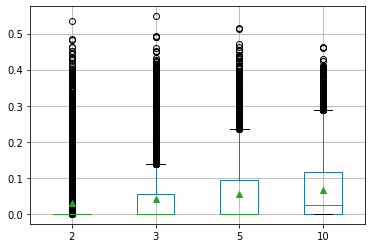

2     0.029430
3     0.042124
5     0.055018
10    0.065906
dtype: float64


In [108]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m)[0]
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

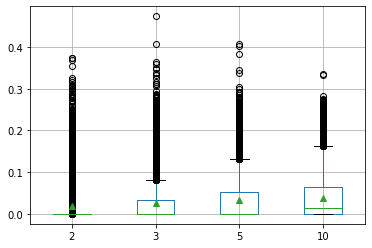

2     0.018505
3     0.025794
5     0.033191
10    0.038460
dtype: float64


In [109]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m,  a=[0.367]*n)[0]
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

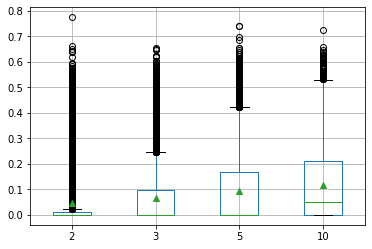

2     0.046689
3     0.067047
5     0.093742
10    0.116480
dtype: float64


In [110]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m,  a=[-0.367]*n)[0]
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

### modifying the estimation uncertainty

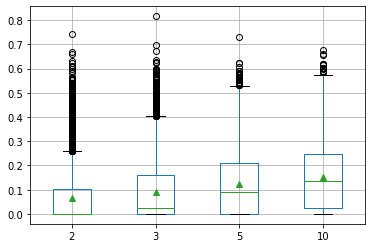

2     0.065400
3     0.092307
5     0.123205
10    0.152767
dtype: float64


In [148]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1])[0]
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

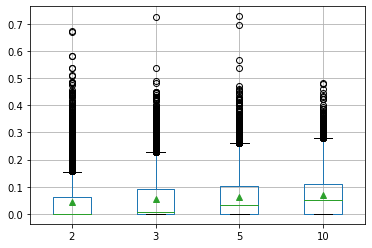

2     0.042955
3     0.054234
5     0.063084
10    0.068769
dtype: float64


In [149]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1], a=[0.367]*3)[0]
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

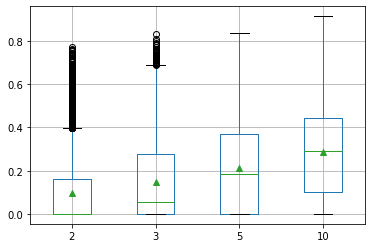

2     0.096298
3     0.149003
5     0.214506
10    0.286141
dtype: float64


In [150]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1], a=[-0.367]*n)[0]
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

# Optimality gap posterior right way

In [162]:
def cal_post_mu(m=5, mu=[0,0,0], s=[1,1,1], t=[1,1,1], w=[1/3, 1/3, 1/3], a=[0,0,0]):
    
    def cal_u(multiatt):
        ul = [u(multiatt[i], a[i], 1) for i in range(len(multiatt))]
        return np.dot(w, ul)
    
    d_list = []
    for k in range(1000):
        x = []
        eu = []
        
        for j in range(m): #loop for generating mu alternatives
            
            n = len(mu) #number of attributes
            x_j = [np.random.normal(mu[i], s[i],1)[0] for i in range(n)] #generate true mu of one alternative
            x.append(cal_u(x_j)) #append u(x) of one mu alternative
            
            y_j = [np.random.normal(x_j[i], t[i],1)[0] for i in range(n)] #generate estimated mu of one alternative
            
            u_x_jp_l = [] #list to store 1000 u(x) of posterior u of one mu alternative 
            for z in range(100):
                u_x_jp = [] #[u_1(x_j1), u_2(x_j2), ...]
                
                for i in range(n): #loop for generating posterior mu for one alternative
                    p_mean = (t[i]**2/(s[i]**2 + t[i]**2))*mu[i] + (s[i]**2/(s[i]**2 + t[i]**2))*y_j[i]
                    p_var = (s[i]**2*t[i]**2/(s[i]**2 + t[i]**2)) 

                    x_ji = np.random.normal(p_mean, np.sqrt(p_var),1)[0]
                    u_x_ji = u(x_ji, a[i], 1)
                    u_x_jp.append(u_x_ji)
                
                
                u_x_jp_l.append(u_x_jp) #append u_x_jp of one posterior alternative (repeated 1000 times)
            
            e = np.mean(u_x_jp_l, axis=0) # E[u(x)|y]           
            eu.append(np.dot(w, e)) #append w_i*E[u(x)|y]

        #Choose the alternative $j^$ with the highest expected utility
        max_eu = max(eu)
        max_j = eu.index(max_eu)

        #posterior disappointment 
        d = (max(x) - x[max_j])/max(x)
        d_list.append(d)
        #Compute the difference $u(x_\tilde{j})-\sum_{k=1}^1000 u_(x_\tilde{j}k)$
    return d_list


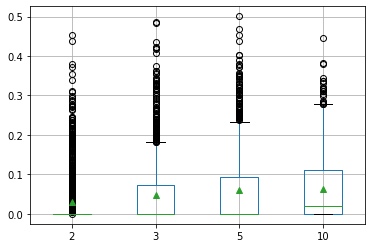

2     0.029251
3     0.048617
5     0.060281
10    0.063286
dtype: float64


In [163]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

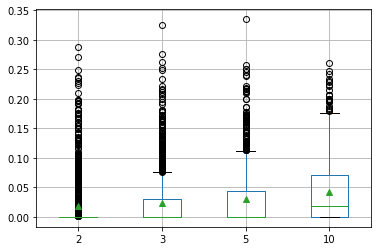

2     0.019081
3     0.024435
5     0.029953
10    0.041471
dtype: float64


In [164]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, a=[0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

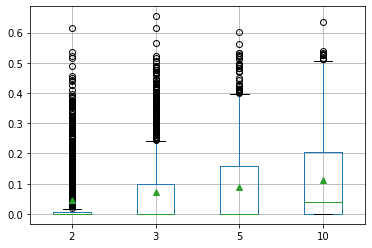

2     0.045535
3     0.072848
5     0.090183
10    0.113229
dtype: float64


In [165]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, a=[-0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

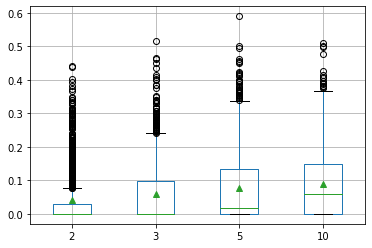

2     0.040381
3     0.058914
5     0.078402
10    0.089863
dtype: float64


In [166]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1])
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

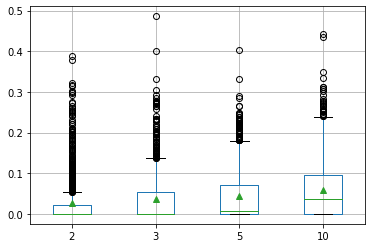

2     0.026540
3     0.036165
5     0.044253
10    0.058383
dtype: float64


In [167]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1], a=[0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

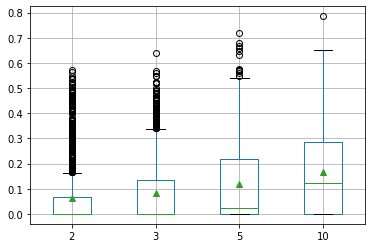

2     0.063778
3     0.082893
5     0.118522
10    0.166392
dtype: float64


In [168]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1], a=[-0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

In [137]:
def cal_post_mu(m=5, mu=[0,0,0], s=[1,1,1], t=[1,1,1], w=[1/3, 1/3, 1/3], a=[0,0,0]):
    
    def cal_u(multiatt):
        ul = [u(multiatt[i], a[i], 1) for i in range(len(multiatt))]
        return np.dot(w, ul)
    
    d_list = []
    for k in range(1000):
        x = []
        eu = []
        
        for j in range(m): #loop for generating mu alternatives
            
            n = len(mu) #number of attributes
            x_j = [np.random.normal(mu[i], s[i],1)[0] for i in range(n)] #generate true mu of one alternative
            x.append(cal_u(x_j)) #append u(x) of one mu alternative
            
            y_j = [np.random.normal(x_j[i], t[i],1)[0] for i in range(n)] #generate estimated mu of one alternative
            
            u_x_jp_l = [] #list to store 1000 u(x) of posterior u of one mu alternative 
            for z in range(100):
                x_jp = []
                
                for i in range(n): #loop for generating posterior mu for one alternative
                    p_mean = (t[i]**2/(s[i]**2 + t[i]**2))*mu[i] + (s[i]**2/(s[i]**2 + t[i]**2))*y_j[i]
                    p_var = (s[i]**2*t[i]**2/(s[i]**2 + t[i]**2)) 

                    x_jp.append(np.random.normal(p_mean, np.sqrt(p_var),1)[0])
                
                u_x_jp = cal_u(x_jp)
                u_x_jp_l.append(u_x_jp) #append u(x) of one posterior alternative (repeated 1000 times)
            
            e = np.mean(u_x_jp_l) #compute the average of 1000 u(x)|y, which is E[u(x)|y]           
            eu.append(e) #append E[u(x)|y]

        #Choose the alternative $j^$ with the highest expected utility
        max_eu = max(eu)
        max_j = eu.index(max_eu)

        #posterior disappointment 
        d = (max(x) - x[max_j])/max(x)
        d_list.append(d)
        #Compute the difference $u(x_\tilde{j})-\sum_{k=1}^1000 u_(x_\tilde{j}k)$
    return d_list


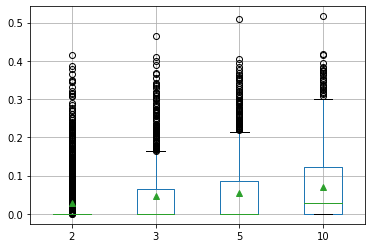

2     0.029281
3     0.046240
5     0.055512
10    0.071242
dtype: float64


In [138]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

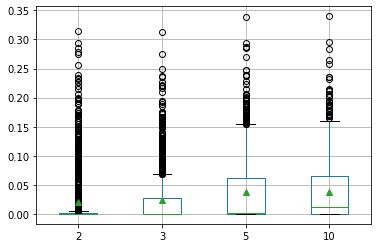

2     0.020261
3     0.024142
5     0.037716
10    0.038159
dtype: float64


In [139]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, a=[0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

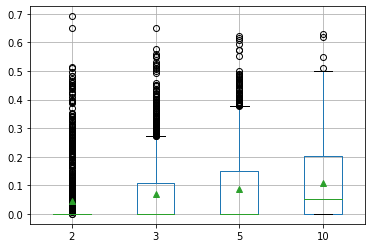

2     0.046645
3     0.071271
5     0.087394
10    0.108747
dtype: float64


In [140]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, a=[-0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

Increase the estimation uncertainty

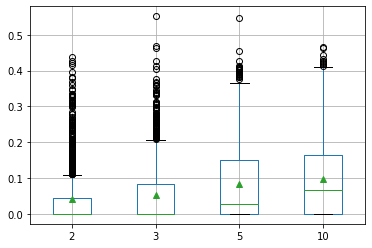

2     0.042046
3     0.052358
5     0.084104
10    0.097502
dtype: float64


In [144]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1])
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

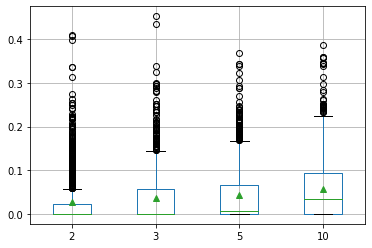

2     0.027593
3     0.037214
5     0.042657
10    0.057850
dtype: float64


In [145]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1], a=[0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

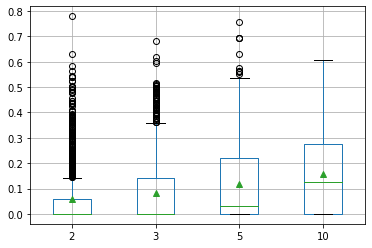

2     0.059752
3     0.082923
5     0.119771
10    0.156323
dtype: float64


In [146]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_mu(m=m, t=[1,5,1], a=[-0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

# Optimality gap posterior wrong way

In [152]:
def cal_post_wrong_mu(m=5, mu=[0,0,0], s=[1,1,1], t=[1,1,1], w=[1/3, 1/3, 1/3], a=[0,0,0]):
    
    def cal_u(multiatt):
        ul = [u(multiatt[i], a[i], 1) for i in range(len(multiatt))]
        return np.dot(w, ul)
    
    d_list = []
    d_mu_list = []
    
    for k in range(10000):
        x = [] #place holder for alternatives
        mx = []
        eu = [] #place holder for posterior estimated utilties
        meu = []
        
        for j in range(m): #loop for generating mu alternatives
            n = len(mu) #number of attributes
            x_j = [np.random.normal(mu[i], s[i],1)[0] for i in range(n)] #generate true m u of one alternative
            x.append(cal_u(x_j)) #append u(x) of one mu alternative
            ux_j= np.array([u(x_j[i], a[i],1) for i in range(n)]) #utilities of individual attributes
            mx.append(ux_j)
            
            y_j = [np.random.normal(x_j[i], t[i],1)[0] for i in range(n)] #generate estimated m u of one alternative
            
            x_jp = []
            
            for i in range(n): #loop for generating posterior m u for one alternative
                p_mean = (t[i]**2/(s[i]**2 + t[i]**2))*mu[i] + (s[i]**2/(s[i]**2 + t[i]**2))*y_j[i]
                p_var = (s[i]**2*t[i]**2/(s[i]**2 + t[i]**2)) 

                x_p_ji = list(np.random.normal(p_mean, np.sqrt(p_var),1000)) #generate 1000 of one attribute 
                x_jp.append(np.mean(x_p_ji)) #append average of that single attribute E[Xji|Y]
                
            eu.append(cal_u(x_jp)) #calculate m u of one alternative
            ux_jp = np.array([u(x_jp[i], a[i],1) for i in range(n)]) #utilities of individual attributes
            meu.append(ux_jp)
        
        #Choose the alternative $j^$ with the highest expected utility
        max_eu = max(eu)
        max_j = eu.index(max_eu)

        #posterior disappointment 
        d = (max(x) - x[max_j])/max(x)
        d_list.append(d)
        d_mu = (mx[max_j]-x[max_j])/mx[max_j]
        d_mu_list.append(d_mu)
        
    return d_list

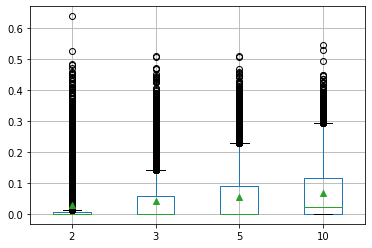

2     0.030019
3     0.042134
5     0.054418
10    0.066776
dtype: float64


In [153]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_wrong_mu(m=m)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

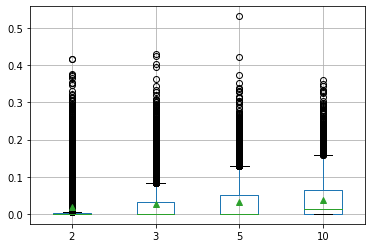

2     0.019627
3     0.026310
5     0.032314
10    0.038421
dtype: float64


In [154]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_wrong_mu(m=m, a=[0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

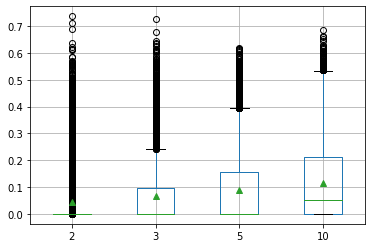

2     0.044666
3     0.065974
5     0.088355
10    0.116817
dtype: float64


In [155]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_wrong_mu(m=m, a=[-0.367]*3)
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

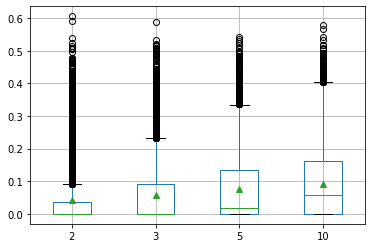

2     0.041514
3     0.056830
5     0.075981
10    0.093155
dtype: float64


In [156]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_wrong_mu(m=m, t=[1,5,1])
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

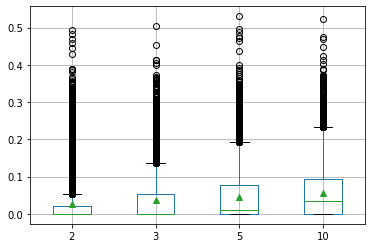

2     0.026207
3     0.036125
5     0.046701
10    0.056340
dtype: float64


In [157]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_wrong_mu(m=m, a=[0.367]*3, t=[1,5,1])
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))

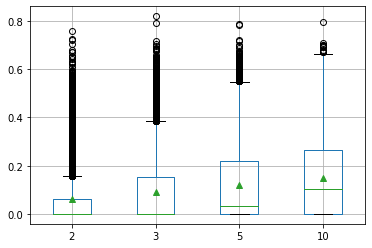

2     0.062540
3     0.089955
5     0.121276
10    0.149040
dtype: float64


In [158]:
d = {}
for m in [2,3,5,10]:
    d[m] = cal_post_wrong_mu(m=m, a=[-0.367]*3, t=[1,5,1])
    
df = pd.DataFrame(d)
df.boxplot(showmeans=True)
plt.show()
print(df.mean(axis=0))